<a href="https://colab.research.google.com/github/edcalderin/LLM_Tech/blob/master/invoice_or_bill_custom_parsing_using_instructor_gpt_4o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Invoice or Bill Custom Parsing using Instructor (Pydantic Extension), Open AI’s GPT-4o & Prompt Engineering

https://blog.gopenai.com/invoice-or-bill-custom-parsing-using-instruction-pydantic-extension-open-ais-gpt-4o-prompt-11e5b7df13be

In [123]:
import base64

image_path: str = "claro.png"

with open(image_path, "rb") as img:
    encoded_image = base64.b64encode(img.read()).decode("utf-8")

encoded_image[:100]

'iVBORw0KGgoAAAANSUhEUgAAAygAAAMvCAYAAAA58fRJAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAAEnQA'

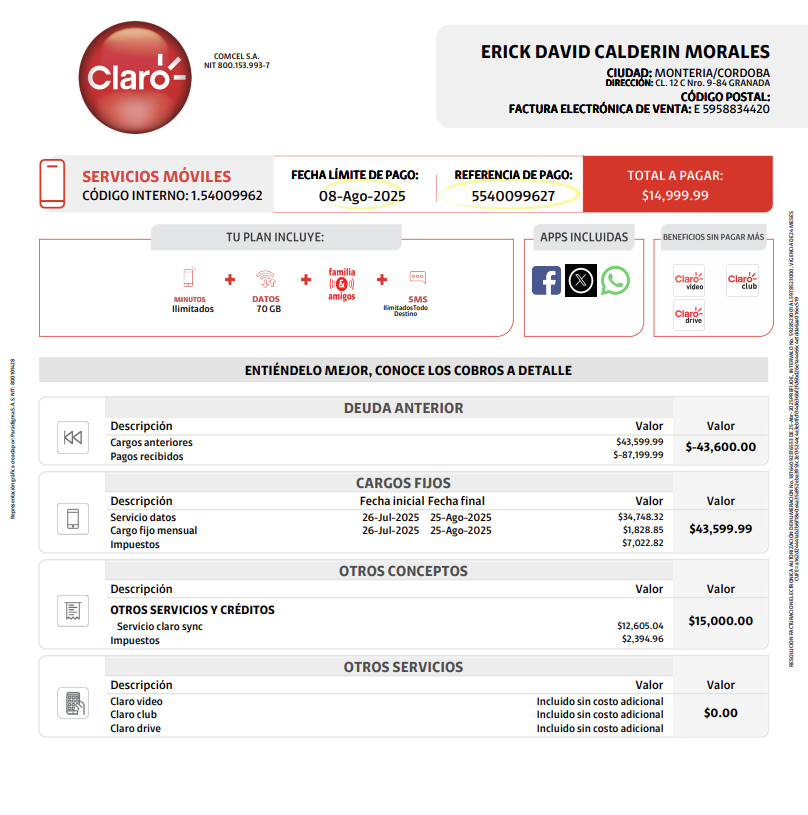

In [124]:
from PIL import Image

Image.open(image_path)

In [ ]:
!pip install -q instructor

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.5/119.5 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 2.8 MB/s eta 0:00:00


In [120]:
# Create models

from datetime import date
from pydantic import BaseModel, Field


class Address(BaseModel):
    name: str = Field(description="name of the person")
    city: str = Field(description="""The city where the person lives
    without the province""")
    state: str = Field(description="Full name of department or province")
    postal_code: str | None = Field(description="""
    Postal code (código postal) extracted from the address section of
    the invoice. May be missing or empty.""")
    electronic_sales_invoice: str = Field(description="""
    Alphanumber code for a sales invoice, which may include letters,
    spaces and digits (e.g., 'E 2321323')""")
    address_description: str = Field(description="Address description")


class InvoiceOverview(BaseModel):
    issue_date: date = Field(description="Due date for the payment")
    payment_code: str = Field(description="""Reference number for
    the payment""")
    total: float = Field(description="Total amount to be paid")


class InvoiceDetails(BaseModel):
    previous_debt: float = Field(
        description="""
        Outstanding debt from previous billing periods
        labeled as 'deuda anterior'""")
    fixed_invoices: float = Field(
        description="Total amount from fixed recurring invoices")
    other_payments: float = Field(
        description="""
        Additional billing items categorized as 'otros conceptos'""")
    other_services: float = Field(
        description="""
        Charges for extra or variable services,
        labeled as 'otros servicios'""")


class Invoice(BaseModel):
    address: Address = Field(
        description="Billing address associated with the invoice")
    invoice_overview: InvoiceOverview = Field(
        description="""Summary information about the invoice,
        including date, total amount, and reference"""
    )
    invoice_details: InvoiceDetails = Field(
        description="""
        Breakdown of the invoice amounts, including previous debts,
        fixed charges, and additional services"""
    )

In [118]:
# Define chat messages

image_url: str = f"data:image/png:base64,{encoded_image}"

user_prompt: str = """
Your goal is to extract structured information from the provided invoice.
"""

text_message: dict[str, str] = {
    "role": "user",
    "content": user_prompt
}

image_message: dict[str, str] = {
    "role": "user",
    "content": [
        {
            "type": "image_url",
            "image_url": {
                "url": image_url
            }
        }
    ]
}

messages: list = [text_message, image_message]

In [119]:
%%time

import instructor
from google.colab import userdata
import os
from pprint import pprint

os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')

client = instructor.from_provider(model="openai/gpt-4o-mini")

response = client.chat.completions.create(
    response_model=Invoice, messages=messages)

pprint(response.model_dump())

{'address': {'address_description': 'Cl. 12 C No. 79-84 Granada',
             'city': 'MONTERIA',
             'electronic_sales_invoice': '5540099627',
             'name': 'ERICK DAVID CALDERIN MORALES',
             'postal_code': '5958834420',
             'state': 'Córdoba'},
 'invoice_details': {'fixed_invoices': 43599.99,
                     'other_payments': 15000.0,
                     'other_services': 0.0,
                     'previous_debt': -43600.0},
 'invoice_overview': {'issue_date': datetime.date(2025, 8, 8),
                      'payment_code': '5540099627',
                      'total': 14999.99}}
CPU times: user 152 ms, sys: 4.38 ms, total: 157 ms
Wall time: 10 s


It failed in the `postal_code` field by providing a non-existing value and in the `electronic_sales_invoice` field by trimming the first character, as shown in the image, even though this was clearly specified in the instructions.

For the reamining fields, it perfomed well 😊.